# Notebook 2: Testing Various Models

In the original paper the train and validation sets were balanced with respect to the class labels however the testing data is very imbalanced. The dataset on the whole is very imbalanced with respect to the classes. We test the following models using mostly the default settings:

1. Logistic Regression
2. Ridge Regression
3. Linear Discriminant Analysis
4. Linear SVM Classifier
5. SGD Classifier
6. Naive Bayes Classifier
7. KNeighbors Classifier
8. Multilayer Perceptron

For models that don't have a predict_proba method we use a softmax to implement a similar functionality for the sake of ensembling over folds.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 49 ms


# Scoring Functions

In [5]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('Holdout Accuracy:', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Logistic Regression

In [6]:
# Logistic Regression
logit_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(
        solver = 'saga',
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.68333 in 2.4s.
Fold 1 Accuracy: 0.6873 in 2.36s.
Fold 2 Accuracy: 0.70714 in 2.35s.
Fold 3 Accuracy: 0.70317 in 2.36s.
Fold 4 Accuracy: 0.71587 in 2.34s.
Fold 5 Accuracy: 0.71032 in 2.36s.
Fold 6 Accuracy: 0.70714 in 2.32s.
Fold 7 Accuracy: 0.69206 in 2.35s.
Fold 8 Accuracy: 0.70159 in 2.37s.
Fold 9 Accuracy: 0.69365 in 2.33s.
Fold 10 Accuracy: 0.72143 in 2.35s.
Fold 11 Accuracy: 0.71326 in 2.37s.

Average CV Accuracy: 0.70302
Worst CV Accuracy: 0.68333
Holdout Accuracy: 0.59368
Training Time: 28.26s



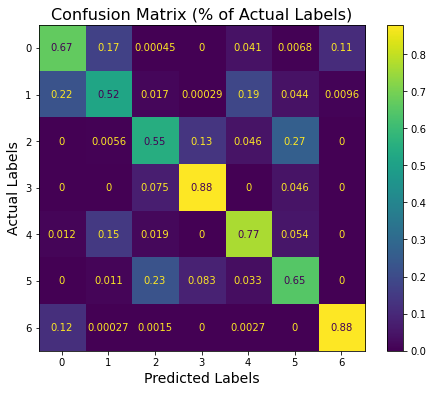

In [7]:
test_score, oof_preds, holdout = train_original(logit_pipeline)

metrics.append((
    'Logistic_Regression', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Ridge Regression

In [8]:
# Class extending Ridge Regression
class ExtendedRidgeClassifier(RidgeClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))
    
# Ridge Regression
ridge_pipeline = make_pipeline(
    RobustScaler(),
    ExtendedRidgeClassifier(
        solver = 'saga',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.62302 in 3.46s.
Fold 1 Accuracy: 0.63889 in 3.49s.
Fold 2 Accuracy: 0.63016 in 3.09s.
Fold 3 Accuracy: 0.63651 in 3.58s.
Fold 4 Accuracy: 0.64444 in 3.61s.
Fold 5 Accuracy: 0.61587 in 3.47s.
Fold 6 Accuracy: 0.65556 in 3.66s.
Fold 7 Accuracy: 0.63889 in 3.52s.
Fold 8 Accuracy: 0.6127 in 3.63s.
Fold 9 Accuracy: 0.61508 in 3.58s.
Fold 10 Accuracy: 0.64921 in 3.67s.
Fold 11 Accuracy: 0.62907 in 3.65s.

Average CV Accuracy: 0.63245
Worst CV Accuracy: 0.6127
Holdout Accuracy: 0.54268
Training Time: 42.42s



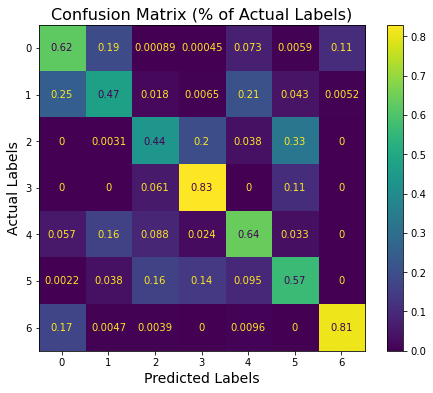

In [9]:
test_score, oof_preds, holdout  = train_original(ridge_pipeline)

metrics.append((
    'Ridge_Regression', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Linear Discriminant Analysis

In [10]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    RobustScaler(),
    LinearDiscriminantAnalysis(),
)

Fold 0 Accuracy: 0.62937 in 0.4s.
Fold 1 Accuracy: 0.65159 in 0.38s.
Fold 2 Accuracy: 0.64841 in 0.37s.
Fold 3 Accuracy: 0.64127 in 0.37s.
Fold 4 Accuracy: 0.66349 in 0.41s.
Fold 5 Accuracy: 0.6373 in 0.42s.
Fold 6 Accuracy: 0.66667 in 0.4s.
Fold 7 Accuracy: 0.65556 in 0.38s.
Fold 8 Accuracy: 0.62063 in 0.4s.
Fold 9 Accuracy: 0.62857 in 0.41s.
Fold 10 Accuracy: 0.66825 in 0.37s.
Fold 11 Accuracy: 0.65449 in 0.37s.

Average CV Accuracy: 0.64713
Worst CV Accuracy: 0.62063
Holdout Accuracy: 0.58125
Training Time: 4.69s



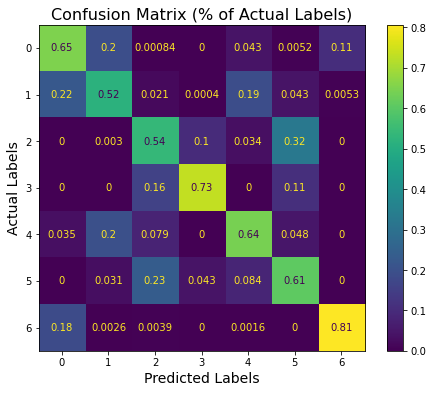

In [11]:
test_score, oof_preds, holdout = train_original(lda_pipeline)

metrics.append((
    'LDA', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LinearSVC

In [12]:
# Extended SGDClassifier
class ExtendedLinearSVC(LinearSVC):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))

# LinearSVC
svc_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedLinearSVC(
        random_state = RANDOM_SEED
    )
)

Fold 0 Accuracy: 0.65635 in 2.04s.
Fold 1 Accuracy: 0.66746 in 2.03s.
Fold 2 Accuracy: 0.68016 in 2.08s.
Fold 3 Accuracy: 0.67302 in 2.1s.
Fold 4 Accuracy: 0.67778 in 2.09s.
Fold 5 Accuracy: 0.66825 in 2.06s.
Fold 6 Accuracy: 0.68571 in 1.96s.
Fold 7 Accuracy: 0.67778 in 2.04s.
Fold 8 Accuracy: 0.6754 in 2.1s.
Fold 9 Accuracy: 0.66508 in 2.0s.
Fold 10 Accuracy: 0.69524 in 2.09s.
Fold 11 Accuracy: 0.67593 in 2.02s.

Average CV Accuracy: 0.67485
Worst CV Accuracy: 0.65635
Holdout Accuracy: 0.55081
Training Time: 24.62s



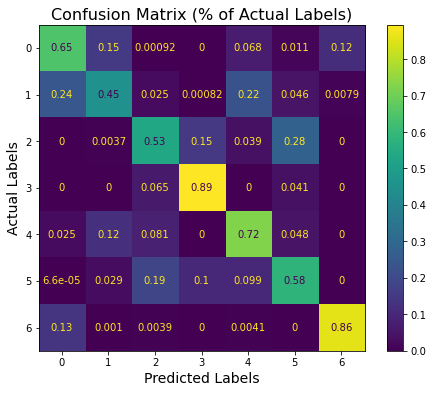

In [13]:
test_score, oof_preds, holdout = train_original(svc_pipeline)

metrics.append((
    'LinearSVC', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# SGDClassifier

In [14]:
# Extended SGDClassifier
class ExtendedSGDClassifier(SGDClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))

# SGDClassifier
sgd_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedSGDClassifier(
        learning_rate = 'optimal', 
        penalty = 'l2', 
        random_state = RANDOM_SEED
    )
)

Fold 0 Accuracy: 0.62937 in 0.64s.
Fold 1 Accuracy: 0.64762 in 0.57s.
Fold 2 Accuracy: 0.6627 in 0.61s.
Fold 3 Accuracy: 0.67063 in 0.58s.
Fold 4 Accuracy: 0.65873 in 0.59s.
Fold 5 Accuracy: 0.62857 in 0.59s.
Fold 6 Accuracy: 0.66746 in 0.59s.
Fold 7 Accuracy: 0.65952 in 0.6s.
Fold 8 Accuracy: 0.65317 in 0.63s.
Fold 9 Accuracy: 0.65714 in 0.64s.
Fold 10 Accuracy: 0.67222 in 0.59s.
Fold 11 Accuracy: 0.6529 in 0.6s.

Average CV Accuracy: 0.655
Worst CV Accuracy: 0.62857
Holdout Accuracy: 0.52924
Training Time: 7.23s



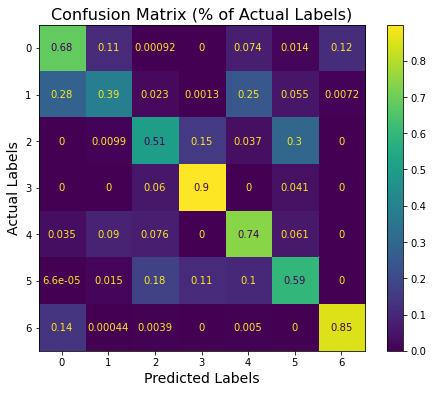

In [15]:
test_score, oof_preds, holdout = train_original(sgd_pipeline)

metrics.append((
    'SGDClassifier', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Naive Bayes Classifier

In [16]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(),
    MultinomialNB(),
)

Fold 0 Accuracy: 0.57222 in 0.49s.
Fold 1 Accuracy: 0.5881 in 0.47s.
Fold 2 Accuracy: 0.59206 in 0.47s.
Fold 3 Accuracy: 0.58968 in 0.47s.
Fold 4 Accuracy: 0.59683 in 0.46s.
Fold 5 Accuracy: 0.58651 in 0.47s.
Fold 6 Accuracy: 0.60952 in 0.48s.
Fold 7 Accuracy: 0.5881 in 0.46s.
Fold 8 Accuracy: 0.56587 in 0.46s.
Fold 9 Accuracy: 0.58651 in 0.46s.
Fold 10 Accuracy: 0.59524 in 0.46s.
Fold 11 Accuracy: 0.59651 in 0.46s.

Average CV Accuracy: 0.58893
Worst CV Accuracy: 0.56587
Holdout Accuracy: 0.50228
Training Time: 5.63s



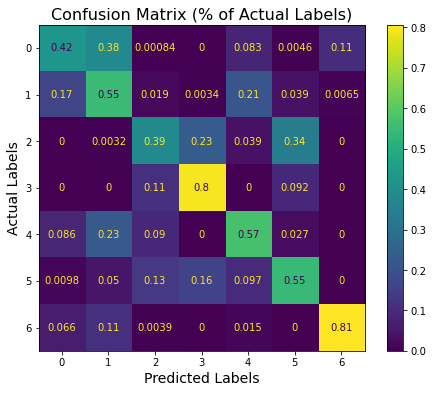

In [17]:
test_score, oof_preds, holdout = train_original(nb_pipeline)

metrics.append((
    'Naive_Bayes', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# KNN Classifier

In [18]:
# Naive Bayes Classifier
knn_pipeline = make_pipeline(
    RobustScaler(),
    KNeighborsClassifier(),
)

Fold 0 Accuracy: 0.79206 in 106.12s.
Fold 1 Accuracy: 0.79286 in 107.44s.
Fold 2 Accuracy: 0.79127 in 110.42s.
Fold 3 Accuracy: 0.77778 in 107.07s.
Fold 4 Accuracy: 0.79683 in 111.78s.
Fold 5 Accuracy: 0.78651 in 110.67s.
Fold 6 Accuracy: 0.79524 in 106.73s.
Fold 7 Accuracy: 0.7881 in 110.19s.
Fold 8 Accuracy: 0.76825 in 110.15s.
Fold 9 Accuracy: 0.79524 in 111.46s.
Fold 10 Accuracy: 0.79683 in 112.44s.
Fold 11 Accuracy: 0.79984 in 109.67s.

Average CV Accuracy: 0.79007
Worst CV Accuracy: 0.76825
Holdout Accuracy: 0.62987
Training Time: 1314.13s



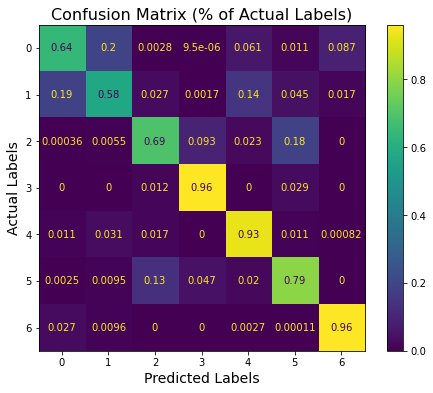

In [19]:
test_score, oof_preds, holdout = train_original(knn_pipeline)

metrics.append((
    'KNN', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Multilayer Perceptron

In [20]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(
        hidden_layer_sizes=(len(features), len(features)//2),
        batch_size = 512, 
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

Fold 0 Accuracy: 0.75476 in 1.88s.
Fold 1 Accuracy: 0.76825 in 1.88s.
Fold 2 Accuracy: 0.76429 in 1.89s.
Fold 3 Accuracy: 0.78095 in 2.5s.
Fold 4 Accuracy: 0.78333 in 2.1s.
Fold 5 Accuracy: 0.78254 in 2.61s.
Fold 6 Accuracy: 0.78968 in 2.08s.
Fold 7 Accuracy: 0.75794 in 2.08s.
Fold 8 Accuracy: 0.77302 in 2.55s.
Fold 9 Accuracy: 0.77302 in 2.03s.
Fold 10 Accuracy: 0.78095 in 2.27s.
Fold 11 Accuracy: 0.76092 in 1.9s.

Average CV Accuracy: 0.77247
Worst CV Accuracy: 0.75476
Holdout Accuracy: 0.64505
Training Time: 25.76s



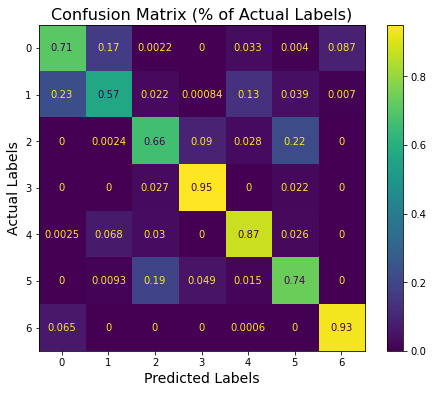

In [21]:
test_score, oof_preds, holdout = train_original(mlp_pipeline)

metrics.append((
    'Multilayer Perceptron', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [22]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','train','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('holdout')

,model,train,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
5,Naive_Bayes,0.588928,0.502275,0.422944,0.550717,0.385295,0.795571,0.570571,0.547051,0.806975
4,SGDClassifier,0.655003,0.529238,0.683556,0.386201,0.505016,0.899489,0.738306,0.594923,0.851880
1,Ridge_Regression,0.632449,0.542679,0.624642,0.472763,0.436136,0.829642,0.635620,0.565661,0.806975
3,LinearSVC,0.674846,0.550813,0.649795,0.452485,0.531299,0.894378,0.724397,0.581443,0.856240
2,LDA,0.647133,0.581255,0.649509,0.517491,0.538384,0.732538,0.640393,0.606957,0.806975
0,Logistic_Regression,0.703023,0.593676,0.666973,0.517886,0.548088,0.879046,0.767899,0.648517,0.876567
6,KNN,0.790066,0.629873,0.639231,0.576497,0.693079,0.959114,0.929360,0.791872,0.960545
7,Multilayer Perceptron,0.772471,0.645050,0.706019,0.567054,0.662896,0.950596,0.873585,0.736174,0.934060
